In [13]:
import os
import qiime2
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from collections import OrderedDict
from matplotlib.font_manager import FontProperties

%matplotlib inline

plt.style.use('fivethirtyeight')

In [14]:
def extract_family(value):
    try:
        family = value.split('D_4__')[1]
        if family == '':
            family = value
    except:
        family = value
    return family

def convert_to_percentages(df, cols):
    df[cols] = df[cols].div(df[cols].sum(axis=0), axis=1).multiply(100)
    return df
    
def get_column_pair(df, col1, col2):
    # Filter columns
    df = df.filter([col1,col2], axis=1)
    
    # Sort
    df = df.sort_values(col1)
    return df

def prepare_df_family(filepath, index_col):
    df = pd.read_csv(filepath, index_col=index_col)

    # Remove all extraneous columns
    df = df.drop((x for x in df.columns.tolist() if x.startswith('D_0__') is False), axis = 1)

    # Transpose
    df = df.transpose()
    df = df.reset_index()

    # Create family column
    df['family'] = df['index'].map(extract_family)

    # Columns to target for conversion to percentage
    columns_to_target = [x for x in df.columns.tolist() if x not in ['index', 'family']]

    # Convert
    df = convert_to_percentages(df, columns_to_target)

    return df
    

def fixed_df(filename, index='sample_annotation'):
    df = prepare_df_family(filename, index)
    new_filename = filename.replace('.csv','_temp.csv')
    
    # Stupid hack
    df.to_csv(new_filename, index=None)
    df = pd.read_csv(new_filename, index_col='family').fillna('NA')
    
    # Cleanup
    os.remove(new_filename)
    return df
    
def load_visualization(filepath):
    """
    :param filepath: path to qiime2 visualization
    :return: qiime2 object containing all information on viz
    """
    data_visualization = qiime2.Visualization.load(filepath)
    return data_visualization
    
def prepare_plot(df, sampleid):
    labels = []
    values = []
    ordered_dict = df.to_dict(into=OrderedDict)[sampleid]
    ordered_dict = OrderedDict(sorted(ordered_dict.items(), key=lambda x: x[1], reverse=True))
    explode = [0 for x in range(len(ordered_dict))]
    explode[0] = 0.07
    explode[1] = 0.05
    explode[2] = 0.03
    explode = tuple(explode)

    for key, value in ordered_dict.items():
        values.append(value)
        if value > 1.5:
            labels.append(key)
        else:
            labels.append('')
    return values, labels, explode
    
def paired_pie_charts(values1, labels1, explode1, sample1, values2, labels2, explode2, sample2):
    
    mpl.rcParams['font.size'] = 9.5

    fig = plt.figure(figsize=(18,10))
    
    ax1 = plt.subplot2grid((2,4),(0,0))
    ax1.pie(values1, labels=labels1, autopct=my_autopct, startangle=90, explode=explode1, shadow=False)
    ax1.axis('equal')
    plt.title(sample1)

    ax2 = plt.subplot2grid((2,4),(0,1))
    ax2.pie(values2, labels=labels2, autopct=my_autopct, startangle=90, explode=explode2, shadow=False)
    ax2.axis('equal')
    plt.title(sample2)

    plt.axis('equal')

    plt.tight_layout(h_pad=20)

    
def create_paired_pie_wrapper(filename, sample1, sample2):
    df = fixed_df(filename)
    (values1, labels1, explode1) = prepare_plot(df, sample1)
    (values2, labels2, explode2) = prepare_plot(df, sample2)
    paired_pie_charts(values1, labels1, explode1, sample1, values2, labels2, explode2, sample2)
    
def my_autopct(pct):
    return (('%.2f' % pct) + '%') if pct > 1.5 else ''

def extract_family_csv(input_path, output_path):
    """
    Output path is direct path to CSV file to create. This is really broken for some weird reason.
    """
    importlib.reload(qiime2)
    # Load visualization file
    try:
        qzv = load_visualization(input_path)
        print('Loaded {}'.format(qzv))
    except:
        print('Could not load .qzv file. Quitting.')
        return None
        
    # Create temporary directory to dump contents into
    temp_dir = os.path.join(os.path.dirname(output_path), 'temporary_qiime2_extraction')
    
    try:
        os.mkdir(temp_dir)
    except:
        shutil.rmtree(temp_dir)
        os.mkdir(temp_dir)

    # Grab CSV
    qzv.export_data(temp_dir)
    family_csv_path = os.path.join(temp_dir, 'level-5.csv')
    
    # Move file
    os.rename(family_csv_path, output_path)
    
    # Cleanup
    shutil.rmtree(temp_dir)
    
    return output_path
    

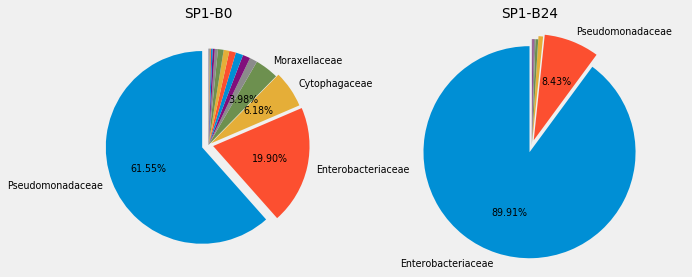

In [12]:
create_paired_pie_wrapper('level-5.csv', 'SP1-B0', 'SP1-B24')
